In [1]:
import json
import pprint
from collections import Counter
from operator import itemgetter
import csv
from dotmap import DotMap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# pulizzia delle stringhe

def clean_up_str(string):
    a = ''
    if string:
        a = string.replace('\xa0', '').replace('  ', ' ').strip()
    return a  



# calcolo dell'anno (medio)

def date(r_col):

    lista=[]
    for v in r_col['values']:
        if v.value.timePrimitive:
            lista.append(int(v.value.timePrimitive.label[:4]))
            
    if len(lista)>=1:
        return int(np.rint(np.mean(lista)))
    else:
        return np.nan




# sintesi time-spen (anno medio: begin, at some time, end)

def datatio(r_col_begin, r_col_someTime, r_col_end, element):

    begin, some_time, end = date(r_col_begin), date(r_col_someTime), date(r_col_end)
    element+= [begin, some_time, end]

    return(element)


## Processetti overview

In [3]:
file = 'geovistory_query_exports/nb_overwiev_processetti_20220510.json'

with open(file, encoding='utf-8') as json_file:
    data = json.load(json_file)

dmData = DotMap(data)
dm_r = dmData.rows
   
    

In [4]:
### Processetti list = psl

psl=[['volume', 'section', 'number_archival_units', 'pk_processetto', 'enquiry', 'motivation_type',
 'start_date','end_date', 'anno', 'id_union', 'number_union']]


for r in dm_r:
    element = []
    # volume
    element += ['-'.join([v.entity_label for v in r.col_0.entities]) if len(r.col_0.entities)>=1 else np.nan]   

    # sezione (unità archivistica)
    element += [clean_up_str(r.col_1.entities[0].entity_label)]

    # numero di section per enquiry 
    element += [len(r.col_1.entities)]

    # enquiry 
    element += [r.col_2.entity.pk_entity, clean_up_str(r.col_2.entity.entity_label)]
   
    # motivation type
    element += [clean_up_str('; '.join([v.entity_label for v in r.col_3.entities])) if len(r.col_3.entities)>=1 else np.nan]

    # arco e anno processetto
    valor = []
    if len(r.col_4['values']) == 0:
        element += [np.nan, np.nan, np.nan]
    else:
        for v in  r.col_4['values']:
            valor.append(int(v.value.timePrimitive.label[:4]))
        element += [r.col_4['values'][0]['value'].timePrimitive.label[:10], r.col_4[
            'values'][len(r.col_4['values'])-1]['value'].timePrimitive.label[:10], round(np.mean(valor))]

    # union
    if len(r.col_5.entities)==1:
        element += [r.col_5.entities[0].pk_entity, len(r.col_5.entities)]
    elif len(r.col_5.entities)>1:
        element += ['-'.join([str(v.pk_entity) for v in r.col_5.entities]) if len(r.col_5.entities)>=1 else np.nan, len(r.col_5.entities)]  
    else:
        element += [np.nan, 0]
        
    psl.append(element)
    

df_proc = pd.DataFrame(psl[1:], columns=psl[0])  
df_proc.head()


,volume,section,number_archival_units,pk_processetto,enquiry,motivation_type,start_date,end_date,anno,id_union,number_union
0,EM 04,Processetto di Giovanni di Michele (da Cessalto),1,1006519,Giovanni di Michele (da Cessalto),Stato libero di “foresto”,1597-05-23,1597-05-23,1597.0,NaN,0
1,EM 05,Processetto di Francesco di Vincenzo Moscato (...,1,1006729,"Francesco di Vincenzo Moscato (da Fabriano, te...",Stato libero di “foresto”,1598-12-27,1598-12-27,1598.0,NaN,0
2,EM 04,Processetto di Pietro di Gennaro Costinovi (da...,1,1006883,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",Stato libero di “foresto”,1597-05-26,1597-05-26,1597.0,NaN,0
3,EM 05,Processetto di Orsola di Angelo Collotis (da V...,1,1007147,Orsola di Angelo Collotis (da Visinale),Stato libero di “foresto”,1598-12-29,1598-12-29,1598.0,NaN,0
4,EM 05,Processetto di Ortensia di Leonardo Verona (da...,1,1007355,Ortensia di Leonardo Verona (da Venzone),Stato libero di “foresto”,1598-12-29,1598-12-29,1598.0,NaN,0


In [5]:
df_proc.volume.unique()

array(['EM 04', 'EM 05', 'EM 25', 'EM 04-EM 06', 'EM 01', 'EM 02',
       'EM 07', 'EM 03', 'EM 08', 'EM 06', 'EM 05-EM 06', 'FC 22',
       'FC 20', 'FC 21', 'EM 16', 'EM 53', 'EM 40', 'EM 11', 'EM 27',
       'EM 17', 'EM 18', 'EM 26', 'EM 04-EM 05'], dtype=object)

### Errori di compilazione della _Section_

#### Errori tipografici nella denominazione della section

In [6]:
# errori tipografici nella denominazione della section

df_proc.loc[df_proc.section.str.contains('(?i)processett')==False]

,volume,section,number_archival_units,pk_processetto,enquiry,motivation_type,start_date,end_date,anno,id_union,number_union
45,EM 04,"Antonio di Giovanni (da Roma, salmistrator)",1,1036013,"Antonio di Giovanni (da Roma, salmistrator)",Stato libero di “foresto”,1597-06-18,1597-06-19,1597.0,NaN,0
101,EM 25,"Giovanni di Valentino Nardis (da Mortegliano, ...",1,1048915,"Giovanni di Valentino Nardis (da Mortegliano, ...",Stato libero di “foresto”,1627-06-11,1627-06-11,1627.0,NaN,0
785,EM 25,Alba di Giovanni Codega (da Padova) vedova di ...,1,1271941,Alba di Giovanni Codega (da Padova) vedova di ...,Vedovanza; Processetto atipico,1627-07-06,1627-07-06,1627.0,NaN,0
1382,EM 07,Bandino Guerra (dalla diocesi di Ceneda),1,1578490,Bandino Guerra (dalla Diocesi di Ceneda),Vedovanza,1603-01-26,1603-01-26,1603.0,NaN,0
1728,EM 01,Processeto di Margherita di Matteo Paulini e d...,1,1721743,"Bartolomeo di Pietro Baldini (da Gargnano, murer)",Stato libero di “foresto”,1600-07-09,1600-07-09,1600.0,NaN,0
2078,EM 07,Elena (dall'Istria) vedova di Antonio (da Gori...,1,1814577,Elena (dall'Istria) vedova di Antonio (da Gori...,Vedovanza,1603-12-21,1603-12-21,1603.0,1814585,1
2083,EM 07,"Andrea di Giacomo Schianetti (da Monfalcone, v...",1,1815777,"Andrea di Giacomo Schianetti (da Monfalcone, v...",Stato libero di “foresto”,1603-12-29,1603-12-29,1603.0,NaN,0
2084,EM 07,Processeto di Alessandro di Benedetto Scalioni...,1,1815912,Alessandro di Benedetto Scallioni (da Ghedi),Stato libero di “foresto”,1603-12-30,1603-12-30,1603.0,NaN,0
2218,FC 22,Mandricardo di Ascanio Rebechini (da Civitanov...,1,1871811,Mandricardo di Ascanio Rebechini (da Civitanov...,Stato libero di “foresto”,1595-04-02,1595-04-02,1595.0,NaN,0
3102,EM 18,"Antonio di Gaspare (da ZImella, tesser da pann...",1,2226043,"Antonio di Gaspare (da Zimella, tesser da pann...",Stato libero di “foresto”,1620-06-29,1620-06-29,1620.0,NaN,0


#### Associazione multiple per section e (no label)

In [7]:
# associazione multiple per section e (no label)

verifica = pd.DataFrame(df_proc.section.value_counts()).reset_index()

df_proc[df_proc.section.isin(verifica.loc[(verifica.section>=2) & (verifica['index'].str.contains(' e ')==False)]['index']) | (df_proc.enquiry=='(no label)')]

,volume,section,number_archival_units,pk_processetto,enquiry,motivation_type,start_date,end_date,anno,id_union,number_union
277,EM 05,Processetto di Evangelista di Pietro (da Ranza...,1,1088023,(no label),Stato libero di “foresto”,1598-11-15,1598-11-15,1598.0,NaN,0
773,EM 25,Processetto di Leonardo di Matteo Gallina (da ...,1,1270290,Leonardo di Matteo Gallina (da Portogruaro),Stato libero di “foresto”,1627-07-04,1627-07-04,1627.0,NaN,0
775,EM 25,Processetto di Leonardo di Matteo Gallina (da ...,1,1270445,(no label),NaN,NaN,NaN,NaN,NaN,0
866,EM 05,Processetto di Evangelista di Pietro (da Ranza...,1,1297960,"Evangelista di Pietro Crescenzi (da Ranzanico,...",Stato libero di “foresto”,1598-11-15,1598-11-15,1598.0,NaN,0
1332,EM 06,Processetto di Gerolama di Pietro Rubeis (da C...,1,1566544,(no label),Stato libero di “foresto”,1600-02-04,1600-02-04,1600.0,NaN,0
1586,EM 06,Processetto di Vincenzo di Giovanni Nante (da ...,1,1673438,"Vincenzo di Giovanni Nante (da Bologna, mercante)",Stato libero di “foresto”,1601-04-24,1601-04-24,1601.0,NaN,0
1599,EM 06,Processetto di Vincenzo di Giovanni Nante (da ...,1,1675607,(no label),NaN,NaN,NaN,NaN,NaN,0
1603,EM 06,Processetto di Antonio di Pietro Bellotti (ber...,1,1676522,(no label),Stato libero di “foresto”,1601-04-26,1601-04-26,1601.0,NaN,0
1627,EM 03,Processetto di Marietta di Floreno Cestari (da...,1,1680487,(no label),Stato libero di “foresto”,1596-05-08,1596-05-08,1596.0,NaN,0
1647,EM 06,Processetto di Faustino di Bartolomeo (da Grevo),1,1683739,(no label),Stato libero di “foresto”,1601-04-28,1601-04-28,1601.0,NaN,0


#### Mancata corrispondenza tra nome del richiedente e denominazione del processetto

In [8]:
# mancata corrispondenza tra nome del richiedente e denominazione del processetto

conteggio = 0
lista_controllo = []
for i, r in df_proc.iterrows():
    if r['enquiry'][:15] not in r['section']:
        conteggio +=1
        lista_controllo.append(r.pk_processetto)


df_proc.loc[df_proc.pk_processetto.isin(lista_controllo) & (df_proc.enquiry!='(no label)')]
         

,volume,section,number_archival_units,pk_processetto,enquiry,motivation_type,start_date,end_date,anno,id_union,number_union
7,EM 04,Processetto di Fillippo Amis (da Bergamo),1,1007777,Filippo Amis (da Bergamo),Vedovanza,1597-05-31,1597-05-31,1597.0,1007767,1
254,EM 25,"Processetto di Erasmo Stairo (da Valdaora, for...",1,1082330,"Erasmo di Giacomo Stairo (da Valdaora, forner)",Stato libero di “foresto” ; Processetto atipico,1627-05-24,1627-05-24,1627.0,NaN,0
256,EM 01,"Processetto di Giacomo Vicenti (da Vicenza, te...",1,1083057,"Giacomo Vincenti (da Vicenza, tesser da panni ...",Stato libero di “foresto”,1592-01-06,1592-01-06,1592.0,NaN,0
344,EM 04,Processetto di Domenico di Vincenzo Meneghini ...,1,1103853,"Vincenzo di Domenico Meneghini (da Chioggia, m...",Stato libero di “foresto”,1597-11-26,1597-11-26,1597.0,NaN,0
732,EM 02,Processetto di Giovanni di Vincenzo Mendoli (n...,1,1253962,Domino,Stato libero di “foresto”,1594-11-26,1595-01-01,1594.0,NaN,0
845,EM 07,Processetto di Pietro Radonini (da Rosina),1,1286280,Pietro di Radonini (da Rosina),Stato libero di “foresto”,1602-02-12,1602-02-13,1602.0,NaN,0
959,EM 25,Processetto di Teodoro di Teofilo Polens (dall...,1,1339660,Teodoro Polens di Teofilo (dalla Prussia),Stato libero di “foresto”,1627-07-19,1627-07-19,1627.0,NaN,0
1150,EM 08,Processetto di Defendi di Angelo Pizzali (da T...,1,1508466,"Defendente di Angelo Pizzali (da Torno, laner)",Stato libero di “foresto”,1604-02-29,1604-02-29,1604.0,NaN,0
1625,EM 03,Processetto di Francesco di Battista Bersanino...,1,1680175,Giovita di Giovanni Antonio Ghirardi (dalla Va...,Stato libero di “foresto”,1596-05-07,1596-05-07,1596.0,NaN,0
1689,EM 03,Processetto di Girolamo di Giovanni Battista S...,1,1700791,"Geronimo di Battista Schenardi (milanese, medico)",Processetto atipico,1596-05-19,1596-05-19,1596.0,NaN,0


#### Assenza di motivation type

In [9]:
# mancanza di motivation type

df_proc[df_proc.motivation_type.isnull()]

,volume,section,number_archival_units,pk_processetto,enquiry,motivation_type,start_date,end_date,anno,id_union,number_union
775,EM 25,Processetto di Leonardo di Matteo Gallina (da ...,1,1270445,(no label),NaN,NaN,NaN,NaN,NaN,0
1599,EM 06,Processetto di Vincenzo di Giovanni Nante (da ...,1,1675607,(no label),NaN,NaN,NaN,NaN,NaN,0
2030,EM 03,Processetto di Nicolò di Gregorio Andreazzi (d...,1,1804518,"Nicolò di Gregorio Andreazzi (da Monfalcone , ...",NaN,1596-11-18,1596-11-18,1596.0,NaN,0
2041,EM 07,Processetto di Giovanni Battista di Andrea Mol...,1,1806269,(no label),NaN,1603-12-14,1603-12-14,1603.0,NaN,0
2549,EM 53,Processetto di Pietro di Nicola Quaia (dalla C...,1,2018187,"Pietro di Nicola Quaia (dalla Carnia, sartor)",NaN,1650-04-24,1650-04-24,1650.0,NaN,0


#### Mancanza dell'Union come motivazione del processetto

In [10]:
# mancanza dell'Union come motivazione del processetto

df_proc[df_proc.motivation_type.str.contains('Vedo') & df_proc.id_union.isnull()]

,volume,section,number_archival_units,pk_processetto,enquiry,motivation_type,start_date,end_date,anno,id_union,number_union
130,EM 25,Processetto di Enea di Bernardo Illario (da Ve...,1,1055799,"Enea di Bernardo Illario (da Venezia, avvocato)",Vedovanza; Processetto atipico,1627-07-03,1627-07-03,1627.0,NaN,0
169,EM 04,Processetto di Elisabetta di Salvatore Colombo...,2,1065023,Elisabetta di Salvatore Colombo (da Napoli) ve...,Vedovanza,1597-08-28,1597-08-30,1597.0,NaN,0
281,EM 25,Processetto di Andrea di Filippo Roat (bresciano),1,1089892,Andrea di Filippo Roat (bresciano),Vedovanza,1627-05-24,1627-05-24,1627.0,NaN,0
785,EM 25,Alba di Giovanni Codega (da Padova) vedova di ...,1,1271941,Alba di Giovanni Codega (da Padova) vedova di ...,Vedovanza; Processetto atipico,1627-07-06,1627-07-06,1627.0,NaN,0
1382,EM 07,Bandino Guerra (dalla diocesi di Ceneda),1,1578490,Bandino Guerra (dalla Diocesi di Ceneda),Vedovanza,1603-01-26,1603-01-26,1603.0,NaN,0
1567,EM 06,Processetto di Giovanni Maria di Virgilio Pinz...,1,1665217,Giovanni Maria di Virgilio Pinzini (mercante),Vedovanza,1600-05-24,1600-05-25,1600.0,NaN,0
1713,EM 06,Processetto di Fiammetta vedova di Pietro (ber...,1,1714185,Fiammetta vedova di Pietro (bergamasco),Vedovanza,1600-07-05,1600-07-05,1600.0,NaN,0
1984,EM 07,Processetto di Francesco di Giacomo Peughi (da...,1,1796676,"Francesco di Giacomo Peughi (da Padova, tesser...",Vedovanza,1603-11-23,1603-11-23,1603.0,NaN,0
2033,EM 03,Processetto di Girolama Nigris (da Venezia),1,1805046,Girolama Nigris (da Venezia),Vedovanza,1596-11-21,1596-11-21,1596.0,NaN,0
2066,EM 03,Processetto di Apollonia di Cristoforo (carnic...,1,1809886,"Apollonia di Cristoforo (carnica), vedova di: ...",Vedovanza,1595-12-31,1595-12-31,1595.0,NaN,0


#### Presenza di più union 
> Da verifcare

In [11]:
# presenza di più union 

df_proc[df_proc.number_union>1]

,volume,section,number_archival_units,pk_processetto,enquiry,motivation_type,start_date,end_date,anno,id_union,number_union
776,EM 04,Processetto di Angela vedova di Francesco Giov...,1,1270509,Angela vedova di Francesco Giovanni Ochiati (d...,Vedovanza,1597-08-05,1597-08-05,1597.0,1270524-1270537,2
2407,EM 16,Processetto di Sebastiano di Gottardo Murari (...,1,1986329,Sebastiano di Gottardo Murari (da Verona),Vedovanza,1620-01-12,1620-01-12,1620.0,1986337-1986343,2
2630,EM 16,Processetto di Caterina vedova di Manolo Manue...,1,2029147,Caterina vedova di Manolo Manuelli (cretese),Vedovanza,1620-02-15,1620-02-15,1620.0,2029154-2107629,2
3079,EM 17,Processetto di Marietta vedova di Ruggero Pere...,1,2215939,Marietta vedova di Ruggero Perei (moliner),Vedovanza,1620-10-02,1620-10-02,1620.0,2215946-2215952,2


#### Assenza della data del processetto

In [12]:
# assenza della data del processetto
df_proc[df_proc.anno.isnull()]

,volume,section,number_archival_units,pk_processetto,enquiry,motivation_type,start_date,end_date,anno,id_union,number_union
99,EM 25,Processetto di Giacomo di Pietro Provezi (da V...,1,1048535,"Giacomo di Pietro Provezi (da Val Cavallina, c...",Stato libero di “foresto”,NaN,NaN,NaN,NaN,0
118,EM 25,Processetto di Geronimo di Stefano Nicoletti (...,1,1053677,"Geronimo di Stefano Nicoletti (da Chiampo, tes...",Stato libero di “foresto”,NaN,NaN,NaN,NaN,0
775,EM 25,Processetto di Leonardo di Matteo Gallina (da ...,1,1270445,(no label),NaN,NaN,NaN,NaN,NaN,0
1367,EM 06,Processetto di Regina di Giorgio (da Retimo),1,1573529,Regina di Giorgio (da Retimo),Stato libero di “foresto”,NaN,NaN,NaN,NaN,0
1562,EM 07,Processetto di Dionora vedova di Domenico di G...,1,1663914,Dionora vedova di Domenico di Giacomo Giovanetti,Vedovanza,NaN,NaN,NaN,1663920,1
1584,EM 06,Processetto di Margherita di Andrea de Angelis...,1,1672770,Margherita di Andrea de Angelis (ferrarese),Stato libero di “foresto”,NaN,NaN,NaN,NaN,0
1599,EM 06,Processetto di Vincenzo di Giovanni Nante (da ...,1,1675607,(no label),NaN,NaN,NaN,NaN,NaN,0
2320,FC 22,Processetto di Giacomo di Michele (da Cipro),1,1893341,Giacomo di Michele (da Cipro),Stato libero di “foresto”,NaN,NaN,NaN,NaN,0
3163,EM 40,Processetto di Giuseppe di Giacomo Zinia (da C...,1,2237272,"Giuseppe di Giacomo Zinia (da Camposampiero, l...",Stato libero di “foresto”,NaN,NaN,NaN,NaN,0


#### Outline cornologici

<AxesSubplot:xlabel='anno'>

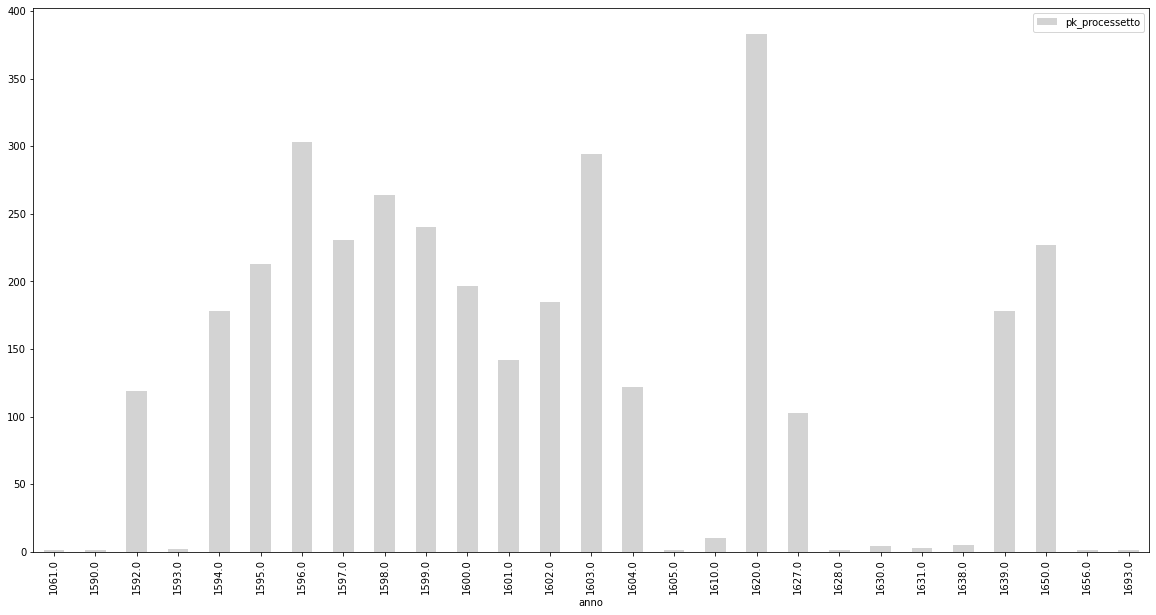

In [13]:
df_proc.groupby('anno').agg({'pk_processetto':'count'}).plot.bar(figsize=(20,10), color='lightgray')

In [14]:
# identificazione degli outline


df_proc[df_proc.pk_processetto.isin(df_proc.sort_values(by='anno', na_position='last').pk_processetto.head(2)) | df_proc.pk_processetto.isin(df_proc.sort_values(by='anno', na_position='first').pk_processetto.tail(2))].sort_values(by='anno')

,volume,section,number_archival_units,pk_processetto,enquiry,motivation_type,start_date,end_date,anno,id_union,number_union
1540,EM 06,Processetto di Pasqua di Michele Iacobati (mas...,1,1657971,Pasqua di Michele Iacobati (massera),Stato libero di “foresto”,1061-12-05,1061-12-05,1061.0,NaN,0
2271,FC 22,"Processetto di Antonio di Leonardo (da Trani, ...",1,1884529,"Antonio di Leonardo (da Trani, mariner)",Stato libero di “foresto”,1590-08-12,1590-08-12,1590.0,NaN,0
2410,EM 53,Processetto di Francesca di Francesco Meneghel...,1,1986791,Francesca di Francesco Meneghelli (da Cagnola),Stato libero di “foresto”,1656-01-06,1656-01-06,1656.0,NaN,0
1404,EM 07,Processetto di Gaspare di Gaspare Ballestra (d...,1,1616092,"Gaspare di Gaspare Ballestra (da Leichlingen, ...",Stato libero di “foresto”,1693-02-04,1693-02-04,1693.0,NaN,0


In [15]:
df_proc[~df_proc.anno.isin(range(1590,1657))&df_proc.anno.notnull()]

,volume,section,number_archival_units,pk_processetto,enquiry,motivation_type,start_date,end_date,anno,id_union,number_union
1404,EM 07,Processetto di Gaspare di Gaspare Ballestra (d...,1,1616092,"Gaspare di Gaspare Ballestra (da Leichlingen, ...",Stato libero di “foresto”,1693-02-04,1693-02-04,1693.0,NaN,0
1540,EM 06,Processetto di Pasqua di Michele Iacobati (mas...,1,1657971,Pasqua di Michele Iacobati (massera),Stato libero di “foresto”,1061-12-05,1061-12-05,1061.0,NaN,0


-----------------------------

## Persone

In [16]:
def controllo_person(df):
    errore = []
    for i, r in df.iterrows():
        if type(r.genere)== float:
            errore.append('genere mancante')
        else:
            errore.append(np.nan)
        if (r.person.split()[0][-1] == 'a') and r.person.split()[0] not in ['Andrea', 'Battista', 'Nicola', 'Geremia', 'Giovita', 'Enea','Ventura', 'Evangelista', 'Luca' ]:
           
            if (type(r.genere) != float) and 'Femm' not in r.genere:
                  errore[i] = '; '.join([errore[i], 'verifica genere']) if type(errore[i])== str else 'verifica genere'
        if type(r.origini)!=float and '(no label)' in r.origini:
            errore[i] = ';'.join([errore[i], 'origini (no label)']) if type(errore[i])==str else 'origini (no label)'
        
        try: 
            if r['età']<10 or r['età']>70:
                errore[i] = ';'.join([errore[i], 'verifica età']) if type(errore[i])==str else 'verifica età'
        except:
            pass
   
    df['errore'] = errore
    df.errore = df.errore.replace('', np.nan)
      
    return df

#### Richiedenti

In [17]:
file = 'geovistory_query_exports/nb_richiedenti_20220510.json'

with open(file, encoding='utf-8') as json_file:
    data_ric = json.load(json_file)

dmr = DotMap(data_ric)

dmr_r = dmr.rows 

In [18]:
# Richiedenti list = rl

rl = [['pk_processetto',  'pk_person', 'person', 'qualità', 'genere', 'origini', 'anno_nascita', 'professioni' ]]


for r in dmr_r:
    for el in r.col_0.entities:
        element = []
        element += [el.pk_entity]

        # pk_person, person, qualità, genere
        element += [r.col_1.entity.pk_entity, clean_up_str(r.col_1.entity.entity_label), 'richiedente', (
            r.col_2.entities[0].entity_label if len(r.col_2.entities)>0 else np.nan)]
        
        # origini
        element += [clean_up_str('; '.join(e.entity_label for e in r.col_3.entities)) if len(r.col_3.entities)>=1 else np.nan]

        # Anno di nascita 
        element += [date(r.col_4)]
        
        # professioni
        element += ['; '.join(e.entity_label for e in r.col_5.entities) if len(r.col_5.entities)>=1 else np.nan]
        
        rl.append(element)


df_ric = pd.DataFrame(rl[1:], columns=rl[0])
df_ric['età'] = df_ric.merge(df_proc[['pk_processetto', 'anno']], on='pk_processetto', how='left')['anno'] - df_ric['anno_nascita']
df_ric = df_ric[['pk_processetto', 'pk_person', 'person', 'qualità', 'età', 'anno_nascita', 'genere', 'origini', 'professioni']]; df_ric.head()



,pk_processetto,pk_person,person,qualità,età,anno_nascita,genere,origini,professioni
0,1006519,1006422,Giovanni di Michele (da Cessalto),richiedente,21.0,1576.0,Maschile,Cessalto,NaN
1,1006883,1006794,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",richiedente,21.0,1576.0,Maschile,Bergamo,cogo; tesser da panni
2,1007147,1006856,Orsola di Angelo Collotis (da Visinale),richiedente,26.0,1572.0,Femminile,Visinale,masser
3,1007355,1007216,Ortensia di Leonardo Verona (da Venzone),richiedente,25.0,1573.0,Femminile,Venzone,masser
4,1007563,1007388,"Vincenzo di Battista Betocchi (da Gandino, cas...",richiedente,26.0,1572.0,Maschile,Gandino,casariol


-----------------------

In [19]:
print(f'non è noto l\'anno di nascita per {len(df_ric[df_ric.anno_nascita.isnull()])} richiedenti su {len(df_ric)}. Vanno tuttavia esclusi i vedovi')

non è noto l'anno di nascita per 711 richiedenti su 3429. Vanno tuttavia esclusi i vedovi


In [20]:
# campione per verifica

df_ric[df_ric.anno_nascita.isnull()].merge(df_proc[df_proc.motivation_type.str.contains('Vedova')==False][['pk_processetto', 'motivation_type', 'volume']], on='pk_processetto')

,pk_processetto,pk_person,person,qualità,età,anno_nascita,genere,origini,professioni,motivation_type,volume
0,1008285,1008160,Domenico di Leonardo Dell’Olivo (da Vito d’Asi...,richiedente,NaN,NaN,Maschile,Vito d'Asio,stampador da libri; soldado; scaleter,Stato libero di “foresto”,EM 05
1,1008665,1008475,"Alessandro di Lorenzo Ferrarini (da Clusone, s...",richiedente,NaN,NaN,Maschile,Clusone,servir in bottega de mercante da colori,Stato libero di “foresto”,EM 05
2,1011331,1011249,"Antonio di Antonio Poli (da Pré, cester)",richiedente,NaN,NaN,Maschile,Pré di Ledro,cestariol,Stato libero di “foresto”,EM 05
3,1012820,1012536,"Matteo di Angelo Della Costa (da Posina, samiter)",richiedente,NaN,NaN,Maschile,Posina,samiter,Stato libero di “foresto”,EM 05
4,1041888,1041834,Tommaso di Giovanni Maria Turra (filator),richiedente,NaN,NaN,Maschile,NaN,filator,Processetto atipico,EM 04
...,...,...,...,...,...,...,...,...,...,...,...
261,778511,778417,"Pietro Maria Canipari (da Crema, fisico)",richiedente,NaN,NaN,Maschile,Crema,fisico,Stato libero di persona lungamente assente da ...,EM 01
262,833146,833043,"Francesco di Tommaso Rocchetta (da Rossano, ma...",richiedente,NaN,NaN,Maschile,Rossano,mariner; masser,Stato libero di “foresto”,EM 05
263,836516,836300,"Antonio di Antonio Burlis (da Fonzaso, samiter)",richiedente,NaN,NaN,Maschile,Fondas,samiter,Stato libero di “foresto”,EM 05
264,986635,986587,Lorenzo di Antonio Donati (da Marano Veneziano...,richiedente,NaN,NaN,Maschile,Marano Veneziano,pistor,Stato libero di “foresto”,EM 05


#### Manca il genere

In [21]:
# Manca il genere 
df_ric[df_ric.genere.isnull()]

,pk_processetto,pk_person,person,qualità,età,anno_nascita,genere,origini,professioni
989,1342779,1342619,Battista di Francesco Ghedini (da Spinone al L...,richiedente,25.0,1574.0,NaN,Spinone al Lago,masser
1160,1508466,1508259,"Defendente di Angelo Pizzali (da Torno, laner)",richiedente,20.0,1584.0,NaN,NaN,laner
2377,1968914,1968817,"Giovanni di Giacomo Pezzetti (da Buja, samiter)",richiedente,20.0,1576.0,NaN,Buja,samiter
2395,1986329,1986161,Sebastiano di Gottardo Murari (da Verona),richiedente,60.0,1560.0,NaN,Verona,NaN
2802,2092800,2092781,"Marietta di Domenico Cruzzoli (da Musano, mass...",richiedente,29.0,1591.0,NaN,Musano,masser
2803,2092956,2092938,Caterina di Pietro Pini (da Venezia) vedova di...,richiedente,NaN,NaN,NaN,Venezia IT,NaN
2804,2093059,2093041,Giacoma di Domenico Vanini vedova di Pietro (d...,richiedente,NaN,NaN,NaN,NaN,NaN


In [22]:
def controllo_genere(df):
    controllo = []
    for i,r in df.iterrows():
        if (r.person.split()[0][-1] == 'a') and r.person.split()[0] not in ['Andrea', 'Battista', 'Nicola', 'Geremia', 'Giovita', 'Enea','Ventura', 'Evangelista' ]:
           
              if (type(r.genere) != float) and 'Femm' not in r.genere:
                controllo.append('verifica')
              else:
                controllo.append(np.nan)
        else:
            controllo.append(np.nan)
            

    return controllo


In [23]:
df_ric['verifica_genere'] = controllo_genere(df_ric)
df_ric[df_ric.verifica_genere.notnull()]


,pk_processetto,pk_person,person,qualità,età,anno_nascita,genere,origini,professioni,verifica_genere
454,1127499,1127449,Angela di Pietro Cortella (dalla Valle Sabbia),richiedente,22.0,1572.0,Maschile,Valle Sabbia,NaN,verifica
572,1152331,1152263,Maddalena di Giacomo Trevisani (da Motta di Li...,richiedente,18.0,1580.0,Maschile,Motta di Livenza,NaN,verifica
640,1199851,1199692,Giovanna (da Venezia) vedova di Antonio Maria ...,richiedente,NaN,NaN,Maschile,Venezia IT,NaN,verifica
738,1253440,1253365,Lucia di Giacomo Tarabotti (da Capodistria),richiedente,14.0,1580.0,Maschile,Capodistria,NaN,verifica
751,1255619,1255478,Olivia di Andrea Belfi (dal Cadore),richiedente,29.0,1565.0,Maschile,Cadore,NaN,verifica
772,1262672,1260740,"Luca di Pietro Radici (da Prata di Pordenone, ...",richiedente,22.0,1576.0,Maschile,Prata di Pordenone,mariner,verifica
951,1331551,1331200,"Luca di Gregorio Costolante (da Curzola, mariner)",richiedente,22.0,1580.0,Maschile,Curzola,mariner,verifica
968,1339737,1335844,Maria di Bartolomeo Fagari (da Lamon),richiedente,20.0,1582.0,Maschile,Lamon,masser,verifica
1035,1473187,1473096,"Clara di Francesco Apolloni (da Cordovado, cam...",richiedente,37.0,1559.0,Maschile,Cordovado,camerier,verifica
1130,1500071,1498740,Caterina di Pietro Torni (da Bassano),richiedente,25.0,1577.0,Maschile,Bassano,masser,verifica


<AxesSubplot:xlabel='età'>

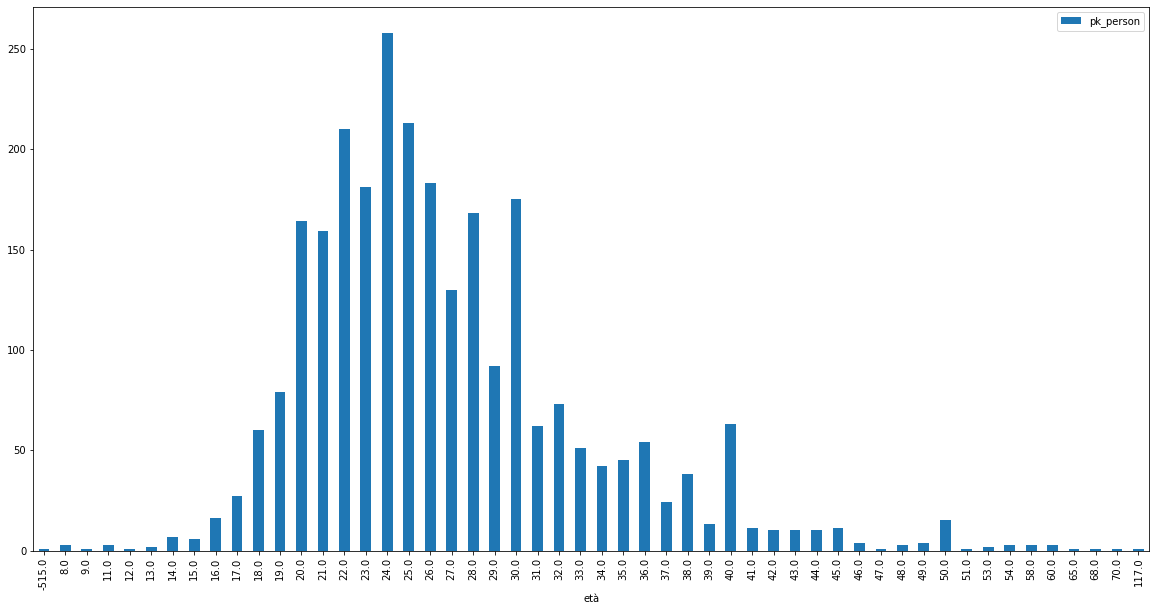

In [24]:
df_ric.groupby('età').agg({'pk_person':'count'}).plot.bar(figsize=(20,10))

In [25]:
df_ric[df_ric['età'].notnull() & (df_ric['età']<14) | (df_ric['età']>60)].merge(df_proc.loc[:, ['pk_processetto', 'volume']], on='pk_processetto', how='left' )

,pk_processetto,pk_person,person,qualità,età,anno_nascita,genere,origini,professioni,verifica_genere,volume
0,1055799,1055699,"Enea di Bernardo Illario (da Venezia, avvocato)",richiedente,70.0,1557.0,Maschile,NaN,avvocato,NaN,EM 25
1,1079648,1078862,"Orazio di Cesare Bertelli (da Roma, sartor)",richiedente,8.0,1586.0,Maschile,Roma IT,sartor,NaN,EM 02
2,1252998,1252883,"Michele di Ulrico (da Augusta, pistor)",richiedente,68.0,1526.0,Maschile,Augusta,fante de pistor; pistor,NaN,EM 02
3,1291695,1291422,"Antonio di Giovanni Cornali (da Ranzanico, fac...",richiedente,9.0,1590.0,Maschile,Ranzanico,fachin,NaN,EM 05
4,1511912,1511837,"Andrea di Pietro Armi (da Bassano, sartor)",richiedente,8.0,1594.0,Maschile,Bassano,sartor,NaN,EM 07
5,1550006,1549924,Felicita di Pietro Lorenzi (da San Nicolò di C...,richiedente,8.0,1594.0,Maschile,San Nicolò di Comelico,masser,verifica,EM 07
6,1616092,1614020,"Gaspare di Gaspare Ballestra (da Leichlingen, ...",richiedente,117.0,1576.0,Maschile,Leichlingen,sartor,NaN,EM 07
7,1657971,1657936,Pasqua di Michele Iacobati (massera),richiedente,-515.0,1576.0,Femminile,NaN,masser,NaN,EM 06
8,1662316,1661987,Michele di Simone Giuliani (da San Daniele del...,richiedente,11.0,1589.0,Maschile,San Daniele del Friuli,NaN,NaN,EM 06
9,1850086,1850002,"Gaspare di Giovanni (da Belluno, forner)",richiedente,13.0,1588.0,Maschile,Belluno,forner,NaN,EM 06


### Origine (no label)

In [26]:
df_ric[df_ric.origini.notnull() & df_ric.origini.str.contains('no lab')]

,pk_processetto,pk_person,person,qualità,età,anno_nascita,genere,origini,professioni,verifica_genere
759,1258483,1258327,Vincenzo di Leonardo Bailo (da Palazzolo della...,richiedente,30.0,1569.0,Maschile,(no label),mariner,NaN
1973,1795145,1795075,Lorenzo di Giovanni Boccia (da Palazzolo dello...,richiedente,24.0,1572.0,Maschile,(no label),squerariol,NaN


-----------------------------

In [27]:
controllo_person(df_ric)
df_ric[df_ric.errore.notnull()]

,pk_processetto,pk_person,person,qualità,età,anno_nascita,genere,origini,professioni,verifica_genere,errore
248,1079648,1078862,"Orazio di Cesare Bertelli (da Roma, sartor)",richiedente,8.0,1586.0,Maschile,Roma IT,sartor,NaN,verifica età
454,1127499,1127449,Angela di Pietro Cortella (dalla Valle Sabbia),richiedente,22.0,1572.0,Maschile,Valle Sabbia,NaN,verifica,verifica genere
572,1152331,1152263,Maddalena di Giacomo Trevisani (da Motta di Li...,richiedente,18.0,1580.0,Maschile,Motta di Livenza,NaN,verifica,verifica genere
640,1199851,1199692,Giovanna (da Venezia) vedova di Antonio Maria ...,richiedente,NaN,NaN,Maschile,Venezia IT,NaN,verifica,verifica genere
738,1253440,1253365,Lucia di Giacomo Tarabotti (da Capodistria),richiedente,14.0,1580.0,Maschile,Capodistria,NaN,verifica,verifica genere
751,1255619,1255478,Olivia di Andrea Belfi (dal Cadore),richiedente,29.0,1565.0,Maschile,Cadore,NaN,verifica,verifica genere
759,1258483,1258327,Vincenzo di Leonardo Bailo (da Palazzolo della...,richiedente,30.0,1569.0,Maschile,(no label),mariner,NaN,origini (no label)
865,1291695,1291422,"Antonio di Giovanni Cornali (da Ranzanico, fac...",richiedente,9.0,1590.0,Maschile,Ranzanico,fachin,NaN,verifica età
968,1339737,1335844,Maria di Bartolomeo Fagari (da Lamon),richiedente,20.0,1582.0,Maschile,Lamon,masser,verifica,verifica genere
989,1342779,1342619,Battista di Francesco Ghedini (da Spinone al L...,richiedente,25.0,1574.0,NaN,Spinone al Lago,masser,NaN,genere mancante


#### Testimoni

In [28]:
file = 'geovistory_query_exports/nb_testimoni_20220510.json'

with open(file, encoding='utf8') as json_file:
    data_tes = json.load(json_file)

dmt = DotMap(data_tes)

dmt_r = dmt.rows 

In [29]:
# Testimone list = rl

tl = [['pk_processetto',  'pk_person', 'person', 'qualità', 'genere', 'origini', 'anno_nascita', 'professioni' ]]


for r in dmt_r:
    for el in r.col_0.entities:
        element = []
        element += [el.pk_entity]

        # pk_person, person, qualità, genere
        element += [r.col_1.entity.pk_entity, clean_up_str(r.col_1.entity.entity_label), 'testimone', (
            r.col_2.entities[0].entity_label if len(r.col_2.entities)>0 else np.nan)]
        
        # origini
        element += [clean_up_str('; '.join(e.entity_label for e in r.col_3.entities)) if len(r.col_3.entities) else np.nan]

        # Anno di nascita 
        element += [date(r.col_4)]
        
        # professioni
        element += ['; '.join(e.entity_label for e in r.col_5.entities) if len(r.col_5.entities) else np.nan]
        
        tl.append(element)


df_tes = pd.DataFrame(tl[1:], columns=tl[0])
df_tes['età'] = df_tes.merge(df_proc[['pk_processetto', 'anno']], on='pk_processetto', how='left')['anno'] - df_tes['anno_nascita']
df_tes = df_tes[['pk_processetto', 'pk_person', 'person', 'qualità', 'età', 'anno_nascita', 'genere', 'origini', 'professioni']]; df_tes.head()

,pk_processetto,pk_person,person,qualità,età,anno_nascita,genere,origini,professioni
0,1006729,1002990,"Giuseppe di Francesco Domiziano (da Fabriano, ...",testimone,53.0,1545.0,Maschile,Fabriano,cimador da panni
1,1006519,1006430,Pietro di Giovanni Maria (da Venezia),testimone,54.0,1543.0,Maschile,Venezia IT,NaN
2,1006519,1006438,"Antonio di Ambrogio Didano (da Bergamo, vender...",testimone,26.0,1571.0,Maschile,Bergamo,vender vin
3,1006519,1006449,"Frizerio di Antonio Zuliani (da Venezia, pesca...",testimone,38.0,1559.0,Maschile,Venezia IT,NaN
4,1006883,1006806,"Ludovico di Ludovico Morando (da Bergamo, tess...",testimone,39.0,1558.0,Maschile,Bergamo,tesser da panni


In [30]:
controllo_person(df_tes)
df_tes[df_tes.errore.notnull()]


,pk_processetto,pk_person,person,qualità,età,anno_nascita,genere,origini,professioni,errore
17,1007933,1007886,Antonio di Antonio Grappolino Bertolini (masser),testimone,64.0,1533.0,NaN,NaN,masser,genere mancante
75,1032025,1031948,"Battista di Giovanni Boralli (da Padova, barbier)",testimone,87.0,1510.0,Maschile,Padova,barbier,verifica età
146,1041471,1041297,Giovanni di Domenico di Cecco (da Cividale del...,testimone,73.0,1554.0,Maschile,Cividale del Friuli,coroner,verifica età
173,1044060,1045167,Lorenzo di Marco Bortazzolo (da Treviso),testimone,43.0,1554.0,NaN,NaN,NaN,genere mancante
209,1048915,1048889,Domenico di Giovanni Battista Chiandolo (da Mo...,testimone,7.0,1620.0,Maschile,Mortegliano,NaN,verifica età
...,...,...,...,...,...,...,...,...,...,...
6840,776278,776094,Filippa vedova di Sebastiano Piniatelli (della...,testimone,5.0,1587.0,Femminile,Lusitania,NaN,verifica età
6902,832921,832736,"Andrea di Bernardo Furlanetto (da Sacile, sartor)",testimone,76.0,1522.0,Maschile,Sacile,sartor,verifica età
6937,929116,929005,Battista di Giovanni Padovano (barbier),testimone,87.0,1510.0,Maschile,NaN,barbier,verifica età
6987,991619,991473,Anna moglie di Paolo Pelix (batioro),testimone,0.0,1598.0,Femminile,NaN,NaN,verifica età


--------------

In [31]:

persons_df = pd.concat([df_ric, df_tes], axis=0, ignore_index=True)

In [32]:
sub_str = []
for e in persons_df.person:
    inizio = e.find('(')
    fine = e.find(')')
    print(e[(inizio+1):fine].split(','))
    # sub_str.append(e[inizio:fine].split(','))


['da Cessalto']
['da Bergamo', ' tesser da panni']
['da Visinale']
['da Venzone']
['da Gandino', ' casariol']
['Santa vedova di Battista di Nicol']
['da Bergamo']
['da Clusone', ' laner']
['da Ampezzo', ' massera']
['da Ampezzo', ' marangon']
['da Vito d’Asio', ' stampador da libri']
['da Valtorta']
['da Clusone', ' servir in bottega di mercante da colori']
['da Bergamo']
['da Gussago', ' petener']
['da Pré', ' cester']
['da Talmassons', ' paternoster']
['da Fonzaso', ' samiter']
['da Feltre', ' masser']
['da Tremosine', ' spechier']
['da Campardo', ' tesser da panni']
['da Posina', ' samiter']
['da Valle Sabbia', ' tesser da panni']
['curamer']
['da Bergamo', ' marzer']
['da Valacchia']
['Battista di Domenico Bert']
['romano', ' masser']
['romano', ' cantor']
['dal Friuli']
['da Chioggia', ' mariner']
['da Semonzo']
['da Villabassa', ' marangon da casse da spechi']
["da Saviore dell'Adamello", ' cester']
["da Saviore dell'Adamello"]
['Maria di Gabriele Tommas']
['da Pordenone']
['da M

### Defunti

In [33]:
file = 'geovistory_query_exports/nb_defunti_20220510.json'

with open(file, encoding='utf-8') as json_file:
    data_def = json.load(json_file)

dmd = DotMap(data_def)

dmd_r = dmd['rows']

In [34]:
# Defunti list = dl
#'pk_processetto', 'pk_person', 'person', 'qualità', 'età', 'anno_nascita', 'genere', 'origini', 'professioni',]]

dl = [['pk_person', 'person', 'qualità', 'genere', 'origini', 'professioni', 'anno_nascita', 'anno_morte', 'luogo_morte', 'id_union', 'union_count', 'type_union', 'pk_person(partner)', 'partner', 'pk_processetto']]

for r in dmd_r:
    element=[]

    # pk_person, person, qualità, genere, origini, professioni
    element += [r.col_0.entity.pk_entity, clean_up_str(r.col_0.entity.entity_label), 'defunto', (r.col_1.entities[0].entity_label if len(r.col_1.entities)>0 else np.nan), (
        ('; '.join(e.entity_label for e in r.col_2.entities)) if len(r.col_2.entities)>=1 else np.nan), ('; '.join(e.entity_label for e in r.col_4.entities) if len(r.col_4.entities)>=1 else np.nan)]

    # anno_nascita
    element += [date(r.col_3)]

    # anno_morte, luogo_morte
    element += [date(r.col_6), ('; '.join(e.entity_label for e in r.col_7.entities) if len(r.col_7.entities)>=1 else np.nan)]
    
    # union, conteggio_unioni, tipo unione
    element += ['-'.join([str(v.pk_entity) for v in r.col_8.entities]) if len(r.col_8.entities)>=1 else np.nan, len(r.col_8.entities), (
        '; '.join(e.entity_label for e in r.col_9.entities) if len(r.col_9.entities)>=1 else np.nan)]
    
    # pk_person(partner), partner
    ## riscrivi
    id_part, part = [], []
    for e in r.col_10.entities:
        if e.pk_entity != r.col_0.entity.pk_entity:
            id_part.append(e.pk_entity)
            part.append(clean_up_str(e.entity_label))
    element += [('-'.join(str(e) for e in id_part) if len(id_part)>=1 else np.nan), ('; '.join(part) if len(part)>=1 else np.nan)]
          
    # pk_processetto
    element += ['-'.join([str(v.pk_entity) for v in r.col_11.entities]) if len(r.col_11.entities)>=1 else np.nan]

    dl.append(element)

df_defs = pd.DataFrame(dl[1:], columns=dl[0])
df_defs.head()

,pk_person,person,qualità,genere,origini,professioni,anno_nascita,anno_morte,luogo_morte,id_union,union_count,type_union,pk_person(partner),partner,pk_processetto
0,1007544,Battista di Nicola,defunto,Maschile,NaN,paron de nave,1543.0,1595.0,NaN,1007670,1,Matrimonio cattolico,1007492,Santa vedova di Battista di Nicola,1007675
1,1007750,Angela (da Bergamo),defunto,Femminile,Territorio di Bergamo,NaN,NaN,1596.0,NaN,1007767,1,Matrimonio cattolico,1007715,Filippo Amis (da Bergamo),1007777
2,1013001,Francesco Bettinelli (curamer),defunto,Maschile,NaN,curamer,NaN,1590.0,S. Aponal,1026547,1,Matrimonio cattolico,1012979,Caterina Albrizzi vedova di Francesco Bettinel...,1026527
3,1032159,Marco Antonio di Francesco Galeotto,defunto,Maschile,Venezia IT,NaN,NaN,1590.0,S. Martin,1032511,1,Matrimonio cattolico,1032116,Bradamante di Francesco Canano (da Pordenone) ...,1032502
4,1038739,"Giovanni di Domenico (da Trieste, mariner)",defunto,Maschile,Trieste IT,mariner,NaN,1597.0,Zante,1038920,1,Matrimonio cattolico,1038725,Caterina di Antonio Manzoni vedova di Giovanni...,1038911


In [35]:
# Integrazione 'controllo person' per defunti
def controllo_def(df):
    errore = []
    df.anno_morte.fillna(0, inplace=True)
    for i, r in df.iterrows():
        errore.append(r.errore)
        if r.anno_morte == 0:
            errore[i] = '; '.join([r.errore, 'anno della morte mancante']) if type(r.errore)!= float else 'anno morte mancante'
        if type(r.id_union) != str:
            errore[i] = '; '.join([r.errore, 'not in union']) if type(r.errore)!=float else 'not in union'
        if type(r.type_union)!=str:
            errore[i]  = '; '.join([r.errore, 'union type mancante']) if type(r.errore)!=float else 'union type mancante'
        if type(r.partner)!=str:
            errore[i] = '; '.join([r.errore, 'partner mancante']) if type(r.errore)!=float else 'partner mancante'

    df['errore'] = errore
    return df   
    # Da completare     


controllo_def(controllo_person(df_defs))

df_defs[df_defs.errore.notnull()]

,pk_person,person,qualità,genere,origini,professioni,anno_nascita,anno_morte,luogo_morte,id_union,union_count,type_union,pk_person(partner),partner,pk_processetto,errore
13,1052687,Sabata di Floriano Moni,defunto,Femminile,NaN,NaN,NaN,0.0,Udine,1052739,1,Matrimonio cattolico,1052659,"Giovanni di Pietro Malagnini (da Imponzo, tess...",1052733,anno morte mancante
30,1090033,Giuseppe di Baldassarre Malotti (grigione),defunto,Maschile,Cantone dei Grigioni,NaN,NaN,1592.0,Creta,1090110,1,NaN,1090025,Domenica (o Margherita) vedova di Giuseppe di ...,1090100,union type mancante
32,1092806,Giulia di Maffeo,defunto,NaN,NaN,NaN,NaN,1595.0,Padova,1094210,1,Matrimonio cattolico,1092798,Francesco di Alessandro Gidolo vedovo di Giuli...,1094197,genere mancante
44,1120150,Giacomo Grisoni,defunto,Maschile,NaN,NaN,NaN,0.0,Isola della Scala,1120195,1,Matrimonio cattolico,1120087,Lisa vedova di Giacomo Grisoni,1120189,anno morte mancante
89,1282009,Pietro (da Serravalle),defunto,NaN,NaN,NaN,NaN,1585.0,Conegliano,1282021,1,Matrimonio cattolico,1281993,Maddalena di Giovanni Gasparetti (da Conegliano),1282124,genere mancante
104,1343336,Geronimo Luna,defunto,Maschile,NaN,NaN,NaN,0.0,Piove di Sacco,1343422,1,Matrimonio cattolico,1343318,Veneranda di Giovanni Maria Marangoni vedova d...,1343416,anno morte mancante
105,1464123,Margherita Boscheria (da Vicenza),defunto,Femminile,Vicenza IT,NaN,NaN,0.0,La Canea,1464363,1,Matrimonio cattolico,1464094,Marco Riegoli (da Treviso) vedovo di Margherit...,1464353,anno morte mancante
106,1464781,Giulia Lombarda,defunto,Femminile,NaN,NaN,NaN,0.0,Pignola,1465068,1,Matrimonio cattolico,1464717,Giovanni Carlo di Benigno Ferramucco (da Potenza),1465051,anno morte mancante
110,1468043,Fabrizio Stoppa (da Treviso),defunto,Maschile,Treviso,NaN,NaN,0.0,Alemania,1468365,1,Matrimonio cattolico,1468028,Bernardina di Pasquale vedova di Fabrizio Stop...,1468358,anno morte mancante
126,1508518,Giovanni di Domenico Bibi,defunto,NaN,NaN,NaN,NaN,1624.0,Tunisi,1508526,1,Matrimonio cattolico,1508497,"Grazia di Vito Muscatello, vedova di Giovanni ...",1508512,genere mancante


### Person name

In [36]:
file = 'geovistory_query_exports/nb_person_name_20220518.json'
with open(file, encoding='utf-8') as json_file:
    data_name = json.load(json_file)

dmpn = DotMap(data_name)
dmpn_r = dmpn.rows

In [37]:

def bon_str(string):
    if type(string) == str and (string != ''):
        string = string.strip().replace('\xa0', '').replace('  ', ' ').lower()
    return string

# Person name list = pnl

pnl = [['pk_person', 'person', 'cognome', 'cognome_count', 'titolo_rispetto', 'titolo_professionale']]

for r in dmpn_r:
    element = []
    element += [r.col_0.entity.pk_entity, r.col_0.entity.entity_label, clean_up_str('; '.join(c.entity_label for c in r.col_1.entities)), len(r.col_1.entities) , bon_str('; '.join(tr.entity_label for tr in r.col_2.entities)),
     bon_str('; '.join(tp.entity_label for tp in r.col_3.entities))]
    pnl.append(element)

df_name = pd.DataFrame(pnl[1:], columns=pnl[0])
df_name.replace('', np.nan, inplace=True)




In [38]:
df_name

,pk_person,person,cognome,cognome_count,titolo_rispetto,titolo_professionale
0,1002990,"Giuseppe di Francesco Domiziano (da Fabriano, ...",Domiziano,1,NaN,NaN
1,1006422,Giovanni di Michele (da Cessalto),NaN,0,NaN,NaN
2,1006430,Pietro di Giovanni Maria (da Venezia),NaN,0,ser,NaN
3,1006438,"Antonio di Ambrogio Didano (da Bergamo, vender...",Didano,1,ser,NaN
4,1006449,"Frizerio di Antonio Zuliani (da Venezia, pesca...",Zuliani,1,ser,NaN
...,...,...,...,...,...,...
10837,999563,Giovanni di Antonio Maiti (da Bergamo),Maiti,1,NaN,NaN
10838,999580,"Vincenzo di Pasini Maiti (da Bergamo, mercante...",Maiti,1,ser,NaN
10839,999599,"Francesco di Vincenzo Moscato (da Fabriano, t...",Moscato,1,domino,NaN
10840,999628,"Giacomo di Giulio Zambellini (da Bergamo, vend...",Zambellini,1,ser,NaN


In [39]:
titoli_r = []
for i,r in df_name.iterrows():
    if type(r.titolo_rispetto)==str:
        for el in r.titolo_rispetto.split('; '):
            titoli_r.append(el)

titoli_r = [e for e in set(titoli_r)]
# print(titoli_r)
titoli_r = ['nobile veneto', 'domino conte', 'illustrissima domina', 'reverendo frate', 'magnifica', 'nobile veronese', 'eccellentissimo domino', 'illustrissimo cavaliere', 
'signora', 'domino', 'messer', 'conte', 'eccellente domino', 'reverendissimo', 'clarissimo', 'reverendo domino', 'eccellentissimo', 'illustrissimo', 'clarissima', 'nobile vicentino', 
'messer dominus', 'madonna domina', 'magnifico ed eccellentissimo domino', 'eccelentissimo domino', 'ser', 'magnifico e eccellentissimo domino', 'eccellente', 'illustrissimo domino', 
'conte e cavaliere', 'messera', 'magnifica domina', 'domina', 'illustrissimo e reverendissimo', 'nobile', 'clarissima domina', 'clarissimo domino', 'cittadino veneziano', 'signor', 'don', 
'reverendo', 'dominus', 'clarisssimo domino', 'eccellentissimo ', 'nobile domina', 'reverendo don', 'madonna', 'vir honestissimus dominus', 'strenuo', 'domini','magnifico',  'nobile domino', 
'magnifico domino']

In [40]:
titoli_p = []
for i,r in df_name.iterrows():
    if type(r.titolo_professionale)==str:
        for el in r.titolo_professionale.split('; '):
            titoli_p.append(el)

titoli_p = [e for e in set(titoli_p)]
print(titoli_p)

['reverendo', 'reverendo presbitero', 'reverendo pre', 'maestro', 'prete', 'presbitero', 'capitano', 'patron', 'magister', 'ambasciatore', 'dottotre (artium et medicinae doctor)', 'ser']


In [41]:
df_name

,pk_person,person,cognome,cognome_count,titolo_rispetto,titolo_professionale
0,1002990,"Giuseppe di Francesco Domiziano (da Fabriano, ...",Domiziano,1,NaN,NaN
1,1006422,Giovanni di Michele (da Cessalto),NaN,0,NaN,NaN
2,1006430,Pietro di Giovanni Maria (da Venezia),NaN,0,ser,NaN
3,1006438,"Antonio di Ambrogio Didano (da Bergamo, vender...",Didano,1,ser,NaN
4,1006449,"Frizerio di Antonio Zuliani (da Venezia, pesca...",Zuliani,1,ser,NaN
...,...,...,...,...,...,...
10837,999563,Giovanni di Antonio Maiti (da Bergamo),Maiti,1,NaN,NaN
10838,999580,"Vincenzo di Pasini Maiti (da Bergamo, mercante...",Maiti,1,ser,NaN
10839,999599,"Francesco di Vincenzo Moscato (da Fabriano, t...",Moscato,1,domino,NaN
10840,999628,"Giacomo di Giulio Zambellini (da Bergamo, vend...",Zambellini,1,ser,NaN


In [42]:
def add_controllo(elemento, testo):
    if type(elemento)==str:
        return f'{testo} = (' + elemento +')'
    else:
        return testo





controllo = []

for i, r in df_name.iterrows():
    if len(r.person.split())==1 and (r.person.lower() not in titoli_r):
            controllo.append('PT errore')
    elif r.person.lower() in titoli_r:
        controllo.append('PT errore')
    else:
        controllo.append(np.nan)

    if type(r.cognome) != float:
        for el in r.cognome.split('; '):
            if (el.lower() in titoli_r):
                controllo[i] = add_controllo(el, 'titolo in cognome')
                
    if type(r.titolo_rispetto)!=float:
        for el in r.titolo_rispetto.split('; '):
            if el not in titoli_r:
                controllo[i] = add_controllo(el, 'titolo errato')
        if (len(r.titolo_rispetto.split('; '))==2) and  (r.titolo_rispetto.split('; ')[0] ==r.titolo_rispetto.split('; ')[1]):
                controllo[i] = add_controllo(el, 'titolo raddoppiato')
    
    if type(r.titolo_professionale)!=float:
        for el in r.titolo_professionale.split('; '):
            if el in titoli_r:
                controllo[i] =  add_controllo(el, 'titolo errato')

df_name['errore'] = controllo
df_name[df_name.errore.notnull()]
 

,pk_person,person,cognome,cognome_count,titolo_rispetto,titolo_professionale,errore
57,1012149,"Ludovico di Faustino Faustini (da Pregasio, sp...",ser; Faustini,2,NaN,NaN,titolo in cognome = (ser)
204,1041135,"Antonio di Cesare (da Venezia, coroner)",NaN,0,domino; domino,NaN,titolo raddoppiato = (domino)
211,1041410,Agricane Dalla Torre (diacono de San Samuel),Dalla Torre,1,reverendo presbitero; domino,NaN,titolo errato = (reverendo presbitero)
237,1044079,"Francesco Paladini (da Pago, canonico de Santa...",Paladini,1,domino; reverendo presbitero,NaN,titolo errato = (reverendo presbitero)
393,1054933,Marietta di Antonio Gastaldione (da Flagogna),Gastaldione; Domina,2,NaN,NaN,titolo in cognome = (Domina)
...,...,...,...,...,...,...,...
10634,828548,Priuli,Priuli,1,NaN,NaN,PT errore
10706,929317,"Battista di Alessandro Tricanati (da Tarvisio,...",Tricanati,1,NaN,ser,titolo errato = (ser)
10719,945953,Paolo di Pietro Minoli (da Zandobbio),Minoli,1,ser; ser,NaN,titolo raddoppiato = (ser)
10803,994175,Giacomo di Simone Coriscelli (da Forni di Sopr...,ser; Coriscelli,2,NaN,NaN,titolo in cognome = (ser)


-----------------------------

### Geographical Place 

In [43]:
file = 'geovistory_query_exports/nb_geographicalPlace.json'

with open(file, encoding='utf-8') as json_file:
    data_gp = json.load(json_file)

dgp = DotMap(data_gp); dgp_r = dgp.rows 

gpl = [['id_gp', 'gp_name', 'gp_type','len_person', 'lat', 'lon']]

for e in dgp_r:
    element = []
    element += [e.col_0.entity.pk_entity, e.col_0.entity.entity_label]
    element += [e.col_2.entities[0].entity_label if len(e.col_2.entities)>=1 else np.nan]
    element+= [len(e.col_3.entities)]
    if len(e.col_4['values'])>0:
        element += [e.col_4['values'][0].value.geometry.geoJSON.coordinates[1]]
        element += [e.col_4['values'][0].value.geometry.geoJSON.coordinates[0]]
    else:
        element += [np.nan, np.nan]
    gpl.append(element)

df_pl = pd.DataFrame(gpl[1:], columns=gpl[0])

In [44]:
def controllo_GeoP(df):
    duplicazione= df.duplicated(subset=['gp_name', 'gp_type'], keep=False)
    errore=[]
    
    for i, e in df.iterrows():
        if e.gp_name =='(no label)':
            errore.append('no label')
        else:
            errore.append(np.nan)
        if type(e.gp_type)!= str:
            errore[i] = '; '.join([errore[i], 'missing type']) if type(errore[i])!=float else 'missing type'
        if e.lat is None:
            errore[i] = '; '.join([errore[i], 'missing coordinates']) if type(errore[i])==str else 'missing cordinates'
        if (duplicazione[i] == True) and (e.gp_name !='(no label)'):
            errore[i] = '; '.join([errore[i], 'possible duplication']) if type(errore[i])==str else 'possible duplication'
    return errore 


In [45]:
df_pl['errore'] = controllo_GeoP(df_pl)

In [46]:
df_pl[df_pl.errore.notnull()]

,id_gp,gp_name,gp_type,len_person,lat,lon,errore
169,1084355,Ballobia,NaN,1,NaN,NaN,missing type
348,1147867,San Giacomo,Luogo abitato,1,44.242400,7.400000,possible duplication
430,1258410,(no label),NaN,2,45.800000,13.083333,no label; missing type
620,1565338,(no label),NaN,0,NaN,NaN,no label; missing type
810,1809616,(no label),NaN,0,NaN,NaN,no label; missing type
850,1883004,San Giacomo,Luogo abitato,1,42.793870,12.752430,possible duplication
958,205236,Amsterdam NL,NaN,2,NaN,NaN,missing type
960,205312,Arles FR,NaN,1,NaN,NaN,missing type
964,205473,Barcelona ES,NaN,1,NaN,NaN,missing type
973,206294,Digione,NaN,1,NaN,NaN,missing type


>   Distribuzione per type

In [47]:
df_pl.groupby(['gp_type']).agg({'id_gp':'count'}).sort_values(by=['gp_type'])

,id_gp
gp_type,
Area geografica,184
Area urbana,11
Città,760
Diocesi,34
Luogo abitato,429
Parrocchia,75
Sestiere,6


In [48]:
import keplergl

In [49]:
# configurazione mappa

config = {'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'z4wto', 'type': 'point', 'config': {'dataId': 'data_1', 'label': 'new layer', 'color': [246, 209, 138], 'highlightColor': [252, 242, 26, 255], 'columns': {'lat': 'lat', 'lng': 'long', 'altitude': None}, 'isVisible': True, 'visConfig': {'radius': 10, 'fixedRadius': False, 'opacity': 0.8, 'outline': False, 'thickness': 2, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'radiusRange': [0, 50], 'filled': True}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': {'name': 'type', 'type': 'string'}, 'colorScale': 'ordinal', 'strokeColorField': None, 'strokeColorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear'}}], 'interactionConfig': {'tooltip': {'fieldsToShow': {'data_1': [{'name': 'pk_entity', 'format': None}, {'name': 'name', 'format': None}, {'name': 'type', 'format': None}, {'name': 'long', 'format': None}]}, 'compareMode': False, 'compareType': 'absolute', 'enabled': True}, 'brush': {'size': 0.5, 'enabled': False}, 'geocoder': {'enabled': False}, 'coordinate': {'enabled': False}}, 'layerBlending': 'normal', 'splitMaps': [], 'animationConfig': {'currentTime': None, 'speed': 1}}, 'mapState': {'bearing': 0, 'dragRotate': False, 'latitude': 43.77402426570166, 'longitude': 11.764379919110501, 'pitch': 0, 'zoom': 3.9423089230580315, 'isSplit': False}, 'mapStyle': {'styleType': 'dark', 'topLayerGroups': {}, 'visibleLayerGroups': {'label': True, 'road': True, 'border': False, 'building': True, 'water': True, 'land': True, '3d building': False}, 'threeDBuildingColor': [9.665468314072013, 17.18305478057247, 31.1442867897876], 'mapStyles': {}}}}

In [50]:
mappa = keplergl.KeplerGl(height=600, data={"data_1": df_pl}, config=config)
mappa

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\Jacopo COSSU\anaconda_surrogato\v_env_surog\lib\site-packages\jupyter_client\session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'z4wto', 'type': 'p…

In [51]:
file = 'geovistory_query_exports/nb_loclaisation_20220512.json'

with open(file, encoding='utf-8') as json_file:
    data_loc = json.load(json_file)

dml = DotMap(data_loc)

dml_r = dml.rows

In [52]:
# Localisation list = ll

ll = [['id_locaisation', 'pk_person', 'person', 'geographical_place', 'GP_type', 'lat', 'lon', 'localisation_type', 'begin', 'at_some_time', 'end', 'occours_before', 'occours_after']]

for r in dml_r:
    element = []

    # id_localisatio, pk_person, person, geo_place + (id), 
    ## valuta la comodità di tenere separato l'ID geographical Place, geographical place, type, coordinate (x,y), localization type 
    element += [r.col_0.entity.pk_entity, r.col_1.entities[0].pk_entity, clean_up_str(r.col_1.entities[0].entity_label), (r.col_2.entities[0].entity_label + f' ({ r.col_2.entities[0].pk_entity})')  if len(
        r.col_2.entities)>0 else np.nan, r.col_10.entities[0].entity_label if len(r.col_10.entities)>=1 else np.nan]
    if len(r.col_12['values'])>0:    
        element += [r.col_12['values'][0].value.geometry.geoJSON.coordinates[0], r.col_12['values'][0].value.geometry.geoJSON.coordinates[1]]
    else:
        element +=[np.nan, np.nan]
    element += [r.col_11.entities[0].entity_label if len(r.col_11.entities)>0 else np.nan]

    # Begin
    element += [round(np.mean([int(r.col_3['values'][0].value.timePrimitive.label[:4]), int(r.col_4['values'][0].value.timePrimitive.label[:4])])) if (len(r.col_3['values'])>0) and (len(r.col_4['values'])>0) else int(
        r.col_3['values'][0].value.timePrimitive.label[:4]) if (len(r.col_3['values'])>0) else int(r.col_4['values'][0].value.timePrimitive.label[:4]) if len(r.col_4['values'])>0 else np.nan]
    
    # At some time within
    element += [int(r.col_5['values'][0].value.timePrimitive.label[:4]) if len(r.col_5['values'])>0 else np.nan]

    # End
    element += [round(np.mean([int(r.col_6['values'][0].value.timePrimitive.label[:4]), int(r.col_7['values'][0].value.timePrimitive.label[:4])])) if (len(r.col_6['values'])>0) and (len(r.col_7['values'])>0) else int(
        r.col_6['values'][0].value.timePrimitive.label[:4]) if (len(r.col_6['values'])>0) else int(r.col_7['values'][0].value.timePrimitive.label[:4]) if len(r.col_7['values'])>0 else np.nan]
  
  
    # Occours before
    element += ['-'.join(str(v.pk_entity) for v in r.col_8.entities) if len(r.col_8.entities)>0 else np.nan]
    
    # Occours after
    element += ['-'.join(str(v.pk_entity) for v in r.col_9.entities) if len(r.col_9.entities)>0 else np.nan]
    
    ll.append(element)

df_loc = pd.DataFrame(ll[1:], columns=ll[0])
df_loc.head()    


,id_locaisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,end,occours_before,occours_after
0,1006461,1006422,Giovanni di Michele (da Cessalto),S. Nicolò (743132),Parrocchia,12.315848,45.432772,Abitazione,NaN,1597.0,NaN,NaN,NaN
1,1006467,999827,"Angelo di Domenico Venturino (da Fabriano, mer...",S. Marziale (743039),Parrocchia,12.332900,45.443800,Abitazione,NaN,1598.0,NaN,NaN,NaN
2,1006473,999827,"Angelo di Domenico Venturino (da Fabriano, mer...",Venezia IT (209678),Città,12.332650,45.437130,Abitazione,1591.0,NaN,NaN,NaN,NaN
3,1006478,1006422,Giovanni di Michele (da Cessalto),Venezia IT (209678),Città,12.332650,45.437130,Abitazione,1586.0,NaN,NaN,NaN,NaN
4,1006544,1006430,Pietro di Giovanni Maria (da Venezia),S. Nicolò (743132),Parrocchia,12.315848,45.432772,Abitazione,NaN,1597.0,NaN,NaN,NaN


In [53]:
df_loc

,id_locaisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,end,occours_before,occours_after
0,1006461,1006422,Giovanni di Michele (da Cessalto),S. Nicolò (743132),Parrocchia,12.315848,45.432772,Abitazione,NaN,1597.0,NaN,NaN,NaN
1,1006467,999827,"Angelo di Domenico Venturino (da Fabriano, mer...",S. Marziale (743039),Parrocchia,12.332900,45.443800,Abitazione,NaN,1598.0,NaN,NaN,NaN
2,1006473,999827,"Angelo di Domenico Venturino (da Fabriano, mer...",Venezia IT (209678),Città,12.332650,45.437130,Abitazione,1591.0,NaN,NaN,NaN,NaN
3,1006478,1006422,Giovanni di Michele (da Cessalto),Venezia IT (209678),Città,12.332650,45.437130,Abitazione,1586.0,NaN,NaN,NaN,NaN
4,1006544,1006430,Pietro di Giovanni Maria (da Venezia),S. Nicolò (743132),Parrocchia,12.315848,45.432772,Abitazione,NaN,1597.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14875,999673,999563,Giovanni di Antonio Maiti (da Bergamo),Venezia IT (209678),Città,12.332650,45.437130,Abitazione,1580.0,NaN,NaN,NaN,NaN
14876,999714,999580,"Vincenzo di Pasini Maiti (da Bergamo, mercante...",S. Eufemia (742937),Parrocchia,12.323600,45.426900,Abitazione,NaN,1597.0,NaN,NaN,NaN
14877,999719,999580,"Vincenzo di Pasini Maiti (da Bergamo, mercante...",Venezia IT (209678),Città,12.332650,45.437130,Abitazione,1580.0,NaN,NaN,NaN,NaN
14878,999734,999628,"Giacomo di Giulio Zambellini (da Bergamo, vend...",S. Geremia (742972),Parrocchia,12.325453,45.442756,Abitazione,NaN,1597.0,NaN,NaN,NaN


#### Possibili errori:
-   Mancanza di geographical_place
-   Mancanza di gp_type
-   Errore di georeferenzazione
-   Mancanza di loc_type
-   Errori nella definizione cronologica

In [54]:
### Frammentarietà dei dati
print('Mancanza di gp:\n')
display(df_loc[df_loc.geographical_place.isnull()])
print('Mancanza di gp_type:\n')
display(df_loc[df_loc.GP_type.isnull()])
print('Mancanza di loc_type:\n')
display(df_loc[df_loc.localisation_type.isnull()])


Mancanza di gp:



,id_locaisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,end,occours_before,occours_after
3186,1217702,1217613,"Orazio di Giovanni Pietro Fantolli (da Onore, ...",NaN,NaN,NaN,NaN,Abitazione,1587.0,NaN,NaN,NaN,NaN
5311,1510141,1510061,"Vincenzo di Giacomo Zin (da Santa Margherita, ...",NaN,NaN,NaN,NaN,Abitazione,NaN,NaN,NaN,NaN,1509981
5735,1551411,1551396,Gaspare di Giulio Manare (da Vigonza),NaN,NaN,NaN,NaN,Abitazione,NaN,1596.0,NaN,NaN,NaN
7589,1701531,1701410,Melchiorre di Mattia (dalla diocesi di Bressan...,NaN,NaN,NaN,NaN,Luogo di lavoro,NaN,1600.0,NaN,NaN,NaN
9350,1825862,1825821,Andrea di Sebastiano Collustoni (da San Daniel...,NaN,NaN,NaN,NaN,Abitazione,NaN,1601.0,NaN,NaN,NaN
9370,1826760,1826729,"Giacomo di Manolo (da La Canea, bombardier e s...",NaN,NaN,NaN,NaN,Abitazione,NaN,1601.0,NaN,NaN,NaN
9383,1827237,1827120,Vincenzo di Bernardino (bergamasco),NaN,NaN,NaN,NaN,Abitazione,1589.0,NaN,NaN,NaN,NaN
11345,2018836,2018812,Andrea di Giacomo Rotta (da Almenno),NaN,NaN,NaN,NaN,Abitazione,1611.0,NaN,NaN,NaN,NaN
11950,2038323,2038283,Giacomo di Girolamo Moschini (da Annone Veneto...,NaN,NaN,NaN,NaN,NaN,1599.0,NaN,NaN,NaN,NaN
11962,2039167,2039148,Ventura di Giacomo Manenti (da Bergamo),NaN,NaN,NaN,NaN,NaN,1634.0,NaN,NaN,NaN,NaN


Mancanza di gp_type:



,id_locaisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,end,occours_before,occours_after
3186,1217702,1217613,"Orazio di Giovanni Pietro Fantolli (da Onore, ...",NaN,NaN,NaN,NaN,Abitazione,1587.0,NaN,NaN,NaN,NaN
3556,1258409,1258342,"Francesco di Battistella Biondo (da Venezia, p...",(no label) (1258410),NaN,13.083333,45.800000,Abitazione,1575.0,NaN,NaN,NaN,NaN
5063,1489532,1489491,"Battista di Lorenzo Rosa (ferrarese, mariner)",Ferrara (769739),NaN,11.619865,44.835297,Abitazione,NaN,NaN,NaN,NaN,NaN
5311,1510141,1510061,"Vincenzo di Giacomo Zin (da Santa Margherita, ...",NaN,NaN,NaN,NaN,Abitazione,NaN,NaN,NaN,NaN,1509981
5735,1551411,1551396,Gaspare di Giulio Manare (da Vigonza),NaN,NaN,NaN,NaN,Abitazione,NaN,1596.0,NaN,NaN,NaN
7102,1673322,1673226,"Girolamo di Pellegrino Zucchi (da Ferrara, par...",Ferrara (769739),NaN,11.619865,44.835297,Abitazione,NaN,1600.0,NaN,NaN,NaN
7103,1673389,1673254,"Giacomo di Antonio Pandolfi (da Ferrara, paron...",Ferrara (769739),NaN,11.619865,44.835297,Abitazione,NaN,1600.0,NaN,NaN,NaN
7589,1701531,1701410,Melchiorre di Mattia (dalla diocesi di Bressan...,NaN,NaN,NaN,NaN,Luogo di lavoro,NaN,1600.0,NaN,NaN,NaN
9350,1825862,1825821,Andrea di Sebastiano Collustoni (da San Daniel...,NaN,NaN,NaN,NaN,Abitazione,NaN,1601.0,NaN,NaN,NaN
9370,1826760,1826729,"Giacomo di Manolo (da La Canea, bombardier e s...",NaN,NaN,NaN,NaN,Abitazione,NaN,1601.0,NaN,NaN,NaN


Mancanza di loc_type:



,id_locaisation,pk_person,person,geographical_place,GP_type,lat,lon,localisation_type,begin,at_some_time,end,occours_before,occours_after
512,1050759,1050662,"Martino di Giovanni Noli (da Augusta, fachin)",Venezia IT (209678),Città,12.332650,45.437130,NaN,1583.0,NaN,NaN,NaN,NaN
690,1059408,1059388,Girolama di Girolamo Brusafoco (da Venezia),Bologna IT (205745),Città,11.338750,44.493810,NaN,1588.0,NaN,NaN,NaN,1059413
2081,1126097,1126071,"Pietro di Giovanni Radici (da Gandino, mariner)",Venezia IT (209678),Città,12.332650,45.437130,NaN,1580.0,NaN,NaN,NaN,NaN
2832,1157863,1157843,Vincenzo di Stefano Drago (da Ragusa),Ragusa IT (208811),Città,14.724430,36.925740,NaN,NaN,1594.0,NaN,NaN,NaN
3376,1249679,1249653,Domenico di Nicolò Molin,Treviso (762519),Città,12.244444,45.665278,NaN,NaN,1594.0,NaN,NaN,NaN
4399,1329414,1329393,Barbara di Bartolomeo Benis (da Como),Venezia IT (209678),Città,12.332650,45.437130,NaN,1588.0,NaN,NaN,NaN,NaN
4416,1331739,1331711,"Antonio di Michele (da Creta, barbier)",Venezia IT (209678),Città,12.332650,45.437130,NaN,1586.0,NaN,NaN,NaN,NaN
4836,1476868,1476849,"Benedetta (da San Vito al Tagliamento, cameriera)",Venezia IT (209678),Città,12.332650,45.437130,NaN,1582.0,NaN,NaN,NaN,NaN
4930,1483581,1480035,Francesco di Giovanni Bettini (da Valle Sabbia...,S. Maria Formosa (743074),Parrocchia,12.341100,45.436900,NaN,NaN,1602.0,NaN,NaN,NaN
5124,1495554,1495432,"Sebastiano di Pietro Solico (da Treviso, servi...",Venezia IT (209678),Città,12.332650,45.437130,NaN,1592.0,NaN,NaN,NaN,NaN


In [55]:
### Errori 
